In [1]:
import torch
from torch import nn
import torchtext
from collections import defaultdict
import time
import matplotlib.pyplot as plt

In [2]:
class BagOfWordsClassifier(nn.Module):
    
    def __init__(self, text_field_vocab, class_field_vocab, emb_dim, dropout=0.5):
        super().__init__()        
        voc_size = text_field_vocab
        n_classes = class_field_vocab    
        self.embedding = nn.Embedding(voc_size, emb_dim)
        self.top_layer = nn.Linear(emb_dim, n_classes)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, docs):
        embedded = self.embedding(docs)
        cbow = embedded.mean(dim=0)
        cbow_drop = self.dropout(cbow)
        scores = self.top_layer(cbow_drop)
        return scores

In [3]:
def read_data(corpus_file, datafields, label_column, doc_start = 2):
    with open(corpus_file) as f:
        examples = []
        for line in f:
            columns = line.strip().split(maxsplit=doc_start)
            doc = columns[-1]
            label = columns[label_column]
            examples.append(torchtext.data.Example.fromlist([doc, label], datafields))
    return torchtext.data.Dataset(examples, datafields)

In [4]:
def evaluate_validation(scores, loss_function, gold):
    guesses = scores.argmax(dim=1)
    n_correct = (guesses == gold).sum().item()
    return n_correct, loss_function(scores, gold).item()

In [5]:
def main():
    
    # Declare fields
    TEXT = torchtext.data.Field(sequential=True, tokenize=lambda x: x.split())
    LABEL = torchtext.data.LabelField(is_target=True)
    datafields = [('text', TEXT), ('label', LABEL)]

    # Read QC dataset
    data = read_data('train_5500.label.txt', datafields, label_column=0)
    
    # Split 90/10
    train, valid = data.split([0.9, 0.1])
    
    # Build vocabularies
    TEXT.build_vocab(train, max_size=10000)
    LABEL.build_vocab(train)
    
    # Declare the model
    model = BagOfWordsClassifier(len(TEXT.vocab), len(LABEL.vocab), emb_dim=16)
    
    # Put the model on the device.
    device = 'cpu'
    model.to(device)
    
    # The BucketIterator groups sentences into similar lengths
    # See here: https://pytorch.org/text/data.html#torchtext.data.BucketIterator
    train_iterator = torchtext.data.BucketIterator(
        train,
        device=device,
        batch_size=56,
        sort_key=lambda x: len(x.text),
        repeat=False,
        train=True)
    
    # The Iterator
    valid_iterator = torchtext.data.Iterator(
        valid,
        device=device,
        batch_size=56,
        repeat=False,
        train=False,
        sort=False)

    # Cross-entropy loss
    loss_function = torch.nn.CrossEntropyLoss()
    
    # Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

    # Create batches
    train_batches = list(train_iterator)
    valid_batches = list(valid_iterator)
    
    # Add history for plotting later
    history = defaultdict(list)
    
    # Loop for 50 epochs
    for i in range(50):
        
        # Reset variables
        t0 = time.time()
        loss_sum = 0
        n_batches = 0

        # Enables the dropout layers.
        model.train()
        
        # We iterate through batches and train the model
        for batch in train_batches:
            scores = model(batch.text)
            loss = loss_function(scores, batch.label)
            optimizer.zero_grad()            
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
            n_batches += 1
        
        train_loss = loss_sum / n_batches
        history['train_loss'].append(train_loss)
        
        # Reset variables
        n_correct = 0
        n_valid = len(valid)
        loss_sum = 0
        n_batches = 0

        # Disable the dropout layers.
        model.eval()
        
        # Compute the loss and accuracy on the validation set.
        for batch in valid_batches:
            scores = model(batch.text)
            n_corr_batch, loss_batch = evaluate_validation(scores, loss_function, batch.label)
            loss_sum += loss_batch
            n_correct += n_corr_batch
            n_batches += 1
        
        val_acc = n_correct / n_valid
        val_loss = loss_sum / n_batches
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)        
        
        t1 = time.time()
        
        # Debug
        print(f'Epoch {i+1}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}, val acc: {val_acc:.4f}, time = {t1-t0:.4f}')
    
    # Plot model
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.plot(history['val_acc'])
    plt.legend(['training loss', 'validation loss', 'validation accuracy'])

Epoch 1: train loss = 3.2753, val loss = 3.0144, val acc: 0.2404, time = 0.3621
Epoch 2: train loss = 2.9060, val loss = 2.6880, val acc: 0.3248, time = 0.3771
Epoch 3: train loss = 2.5249, val loss = 2.3704, val acc: 0.4183, time = 0.3331
Epoch 4: train loss = 2.1384, val loss = 2.0974, val acc: 0.4881, time = 0.3481
Epoch 5: train loss = 1.8077, val loss = 1.8950, val acc: 0.5211, time = 0.3681
Epoch 6: train loss = 1.5178, val loss = 1.7521, val acc: 0.5541, time = 0.3331
Epoch 7: train loss = 1.2667, val loss = 1.6575, val acc: 0.5817, time = 0.3344
Epoch 8: train loss = 1.0643, val loss = 1.5848, val acc: 0.6037, time = 0.3521
Epoch 9: train loss = 0.9290, val loss = 1.5295, val acc: 0.6202, time = 0.3451
Epoch 10: train loss = 0.8099, val loss = 1.5134, val acc: 0.6220, time = 0.3594
Epoch 11: train loss = 0.7196, val loss = 1.5025, val acc: 0.6330, time = 0.3411
Epoch 12: train loss = 0.6351, val loss = 1.4859, val acc: 0.6312, time = 0.3611
Epoch 13: train loss = 0.5651, val lo

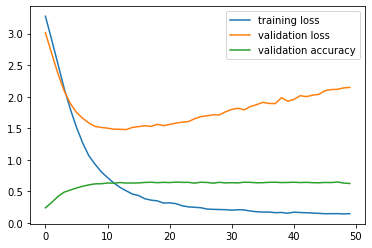

In [6]:
main()